# Lab | Sequence Modeling with LSTM

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Load the dataset
df = pd.read_csv('dataset.csv')  # Make sure your CSV file is in the correct path
text_col = 'Text'
label_col = 'Category'

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1490, 3)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


# =============================================================================
# EXERCISE 1: TEXT PREPROCESSING
# =============================================================================

In [4]:

def clean_text(text):
    """
    Clean and preprocess text data
    TODO: Complete this function to:
    1. Convert text to lowercase
    2. Remove all characters except letters and spaces using regex
    3. Return the cleaned text
    """
    # TODO: Convert to lowercase
    text = text.lower()
    
    # TODO: Remove non-alphabetic characters (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    return text

# Apply text cleaning
df[text_col] = df[text_col].astype(str).apply(clean_text)

print("Sample cleaned texts:")
print(df[text_col].head(3).tolist())

Sample cleaned texts:
['worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness  cynthia cooper  worldcom s exhead of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in  her warnings led to the collapse of the firm following the discovery of an bn bn accounting fraud mr ebbers has pleaded not guilty to charges of fraud and conspiracy  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early  and  she said andersen had given a  green light  to the procedures and practices used by worldcom mr ebber s la

# =============================================================================
# EXERCISE 2: LABEL ENCODING
# =============================================================================


In [5]:

# TODO: Initialize LabelEncoder and encode the labels
encoder = LabelEncoder()
df[label_col] = encoder.fit_transform(df[label_col])

num_classes = len(encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {encoder.classes_}")


Number of classes: 5
Classes: ['business' 'entertainment' 'politics' 'sport' 'tech']



# =============================================================================
# EXERCISE 3: TEXT TOKENIZATION AND PADDING
# =============================================================================


In [6]:

# TODO: Initialize tokenizer with out-of-vocabulary token
tokenizer = Tokenizer(oov_token='<OOV>')

# TODO: Fit tokenizer on texts
tokenizer.fit_on_texts(df[text_col])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# TODO: Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df[text_col])

# TODO: Pad sequences to max_len=100
max_len = 100
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

print(f"Padded sequences shape: {padded.shape}")


Vocabulary size: 25379
Padded sequences shape: (1490, 100)



# =============================================================================
# EXERCISE 4: TRAIN-VALIDATION-TEST SPLIT
# =============================================================================


In [7]:
# TODO: Split data into train (70%), validation (15%), and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    padded, df[label_col], test_size=0.15, random_state=42, stratify=df[label_col]
)

# =============================================================================
# EXERCISE 5: LOAD PRE-TRAINED EMBEDDINGS (OPTIONAL)
# ============================================================================


In [8]:
# TODO: Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")


Loaded 0 word vectors from GloVe.


# =============================================================================
# EXERCISE 6: BUILD MODEL FUNCTION
# =============================================================================


In [9]:
# Build RNN or LSTM model
# TODO: Complete this function to build the neural network
def build_model(vocab_size, embedding_dim, max_len, num_classes, embeddings_index):
    model = Sequential()
    # Embedding layer with optional GloVe weights
    if embeddings_index:
        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        model.add(Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_len,
            weights=[embedding_matrix],
            trainable=False
        ))
    else:
        model.add(Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_len
        ))
    # LSTM layer
    model.add(LSTM(128, return_sequences=False))
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    return model


# =============================================================================
# EXERCISE 7: MODEL TRAINING AND EVALUATION
# =============================================================================


In [10]:
# Build model
embedding_dim = 100  # GloVe embedding size
model = build_model(vocab_size, embedding_dim, max_len, num_classes, embeddings_index)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_val, y_train_val,
    validation_split=0.15,
    epochs=10,
    batch_size=32,
    callbacks=[es]
)

# Make predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate classification report
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


c:\Users\User\Desktop\Ironhack-DS-AI\week-32\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2537 - loss: 1.5917 - val_accuracy: 0.2632 - val_loss: 1.5479
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4582 - loss: 1.1364 - val_accuracy: 0.4211 - val_loss: 1.1369
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7537 - loss: 0.8369 - val_accuracy: 0.5368 - val_loss: 1.9446
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8513 - loss: 0.6250 - val_accuracy: 0.8474 - val_loss: 0.4739
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9545 - loss: 0.2195 - val_accuracy: 0.8684 - val_loss: 0.4938
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9507 - loss: 0.1674 - val_accuracy: 0.7105 - val_loss: 0.8642
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9219 - loss: 0.3690 - val_accuracy: 0.7895 - val_loss: 0.5637
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
               precision    recall  f1-score   support

     business    


# =============================================================================
# EXERCISE 8: VISUALIZATION
# =============================================================================


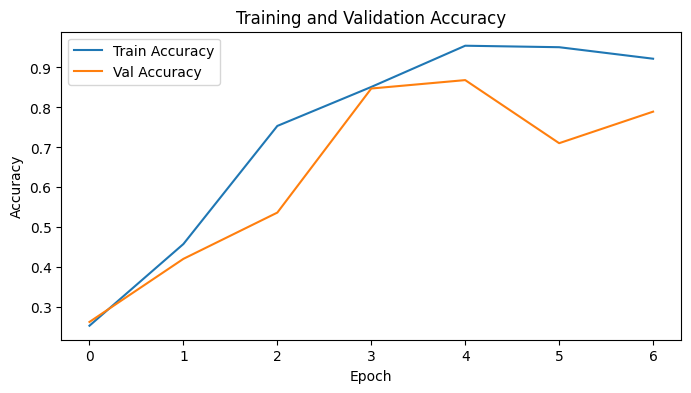

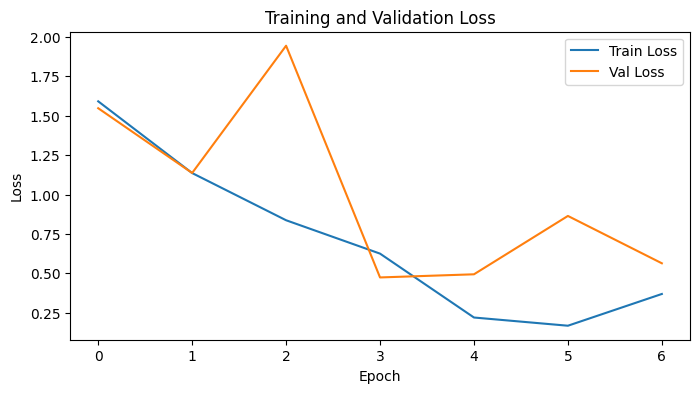

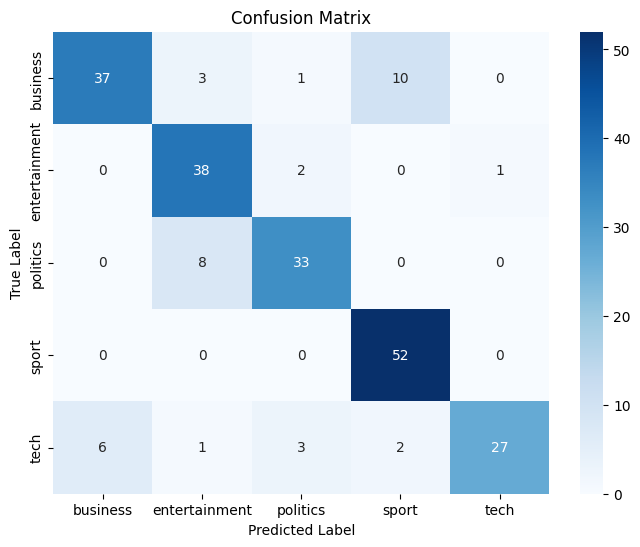

In [13]:
# Plot training accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



# =============================================================================
# EXERCISE 9: RESULTS ANALYSIS
# =============================================================================


In [14]:
# Add best validation metrics to results
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")


Best Validation Accuracy: 0.8684
Best Validation Loss: 0.4739


EXERCISE COMPLETE!